## Parameter tuning with `PredictTutor` class.

This class assumes the next point or set of points to check.
- Multi and single objective
- Models portfolio
- If there is no correct model takes a point from the sampling plan.
- Random or Sobol sequence sampling plan.

> "For 800 years have I trained Jedi." ―Yoda, to Luke Skywalker

In [5]:
import sys
sys.path.append('..')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from src.composite import PredictTutor, ModelsUnion
from src.generator import SamplesGenerator
from src.ploting import plot_mo

from src.hypothesis.tpot_estimator import TpotWrp
from src.hypothesis.custom_gp_kernel import KERNEL_MAUNA, KERNEL_SIMPLE, KERNEL_GPML

### Problem definition

In [6]:
DIM = 2
ID = 4
OBJ = 2

# --- Problem
udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)
# udp = pg.zdt(prob_id=ID, param=DIM)
pro = pg.problem(udp)

### Initialization a models for portfolio

In [7]:
# 1
tea_pot = TpotWrp(generations=2, population_size=10, random_state=42) 
# 2
gp_sim = gp.GaussianProcessRegressor(kernel=KERNEL_SIMPLE, alpha=0, n_restarts_optimizer=10, normalize_y=True) 
# 3
grad_uni = ModelsUnion(
    models=[GradientBoostingRegressor(n_estimators=200)],
    split_y=True) 
# 4 
lin_uni = ModelsUnion(models=[LinearRegression()], split_y=True)

### Prediction tutor

In [8]:
gen = SamplesGenerator(pro)
tutor = PredictTutor(pro.get_bounds(), portfolio=[tea_pot, gp_sim, grad_uni, lin_uni])

iter_solution = []
x=0
while x < 300:
    x=x+1
    print("\n--- {}".format(x))
    X, y = gen.return_X_y()
    iter_solution.append(tutor.solution)
    propos = tutor.next_config(X, y, n=1, cv=4)
    gen.update(propos.tolist(), [pro.fitness(p).tolist() for p in propos])


--- 1
Initialization data generator

--- 2
In dataset add 1 new results

--- 3
In dataset add 1 new results

--- 4
In dataset add 1 new results

--- 5
In dataset add 1 new results

--- 6
In dataset add 1 new results

--- 7
In dataset add 1 new results

--- 8
In dataset add 1 new results

--- 9
In dataset add 1 new results

--- 10
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 11
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 12
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 13
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 14
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 15
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 16
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 17
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 18
Split dataset. Validation is 0.25%
In dataset add 1 new results

--- 19
Split dataset. Vali

___
### Results analysis

In [9]:
X, y = gen.return_X_y()
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(y.values)
ndf_in_total = 100*(len(ndf[0])/len(X))
y.reset_index(drop=True, inplace=True)

print("Evaluated {} point(s). Non-dominated solutions is {:.1f}% from all dataset".format(len(X), ndf_in_total))
print("Hypervolume: {:.2f}".format(pg.hypervolume(-y.loc[ndf[0],:].values).compute([0]*OBJ)))

Evaluated 300 point(s). Non-dominated solutions is 29.7% from all dataset
Hypervolume: 6.25


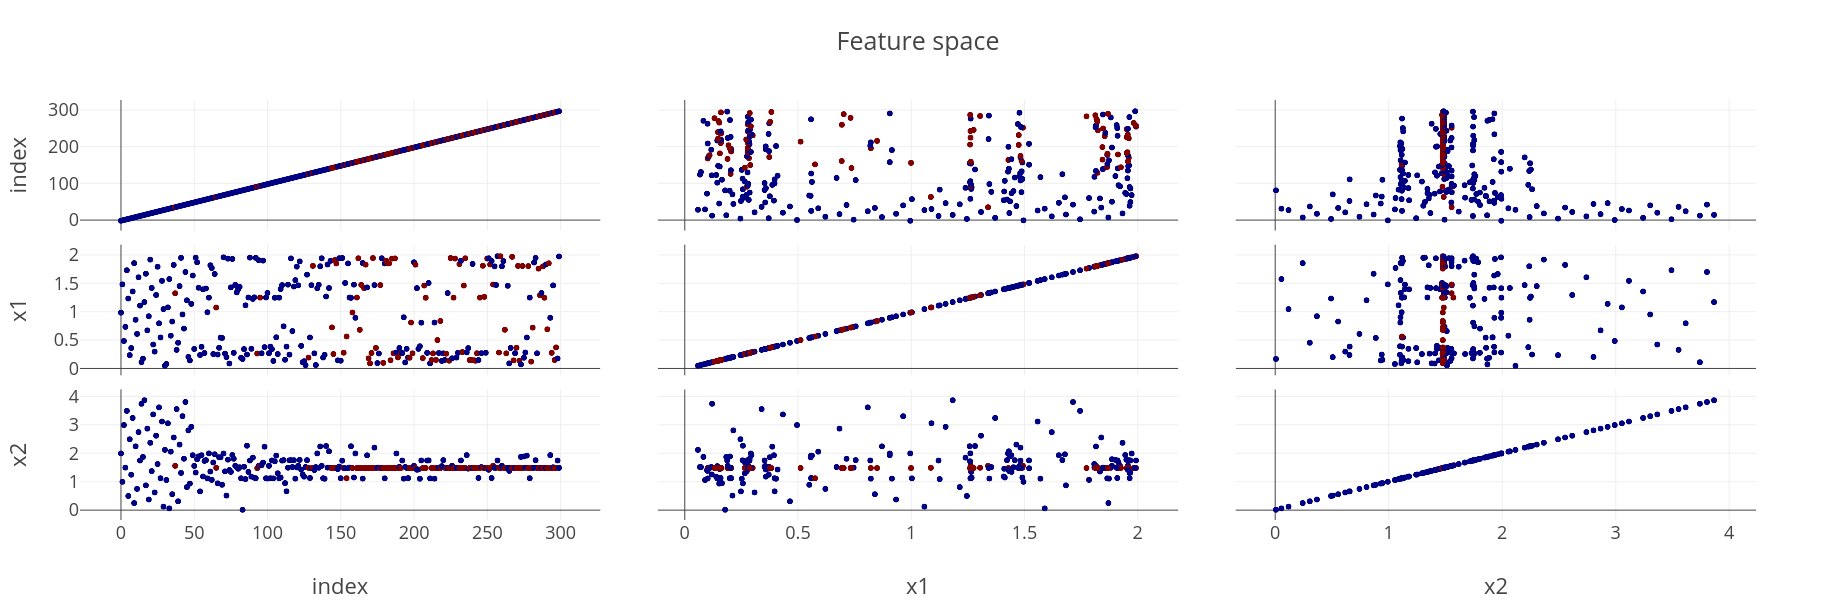

In [45]:
X_ndf = X.copy().reset_index()
X_ndf['ndf'] = 0
X_ndf.loc[ndf[0],['ndf']] = 1
px.scatter_matrix(X_ndf, template="presentation" , dimensions=list(X.columns), color='ndf', color_continuous_scale='Jet', title="Feature space").update_layout(coloraxis_showscale=False)

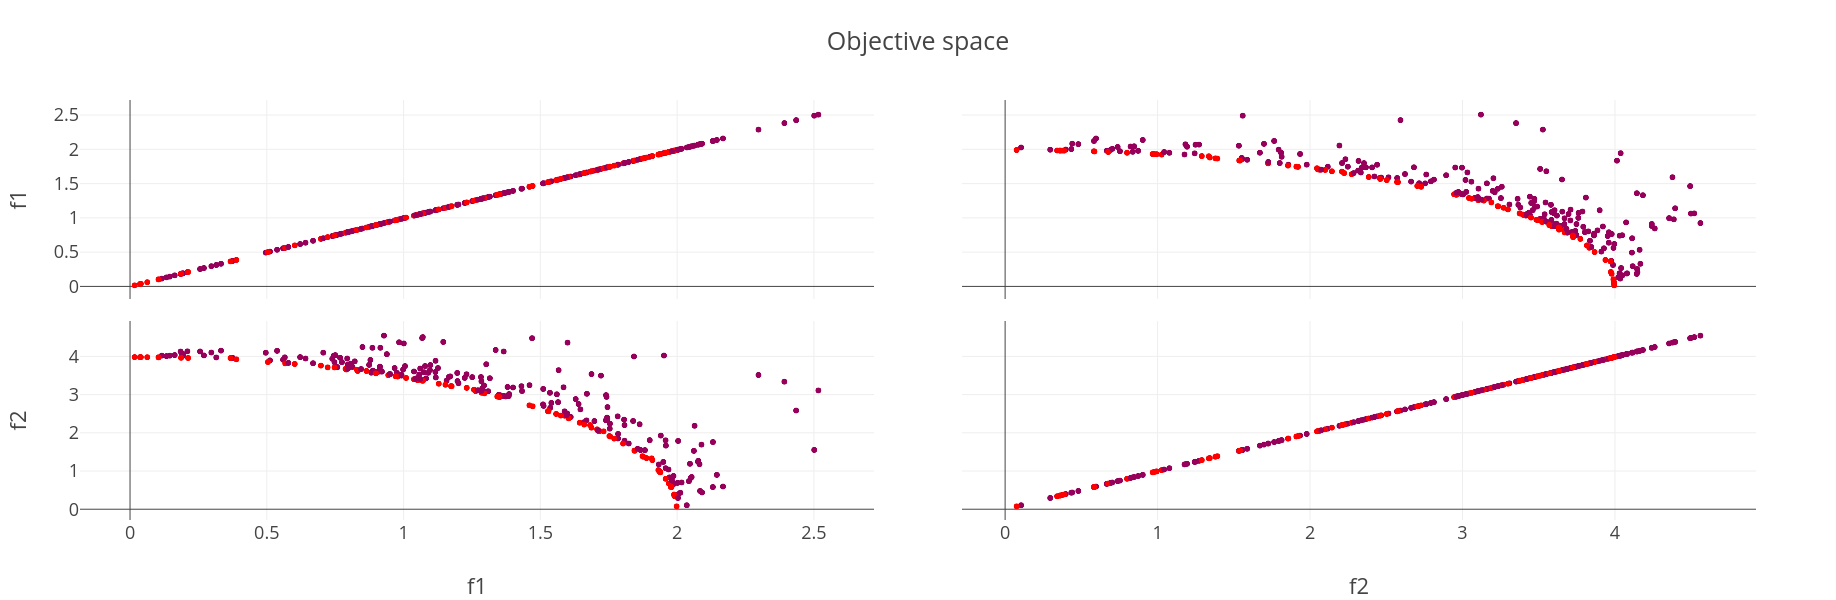

In [11]:
y_ndf = y.copy().reset_index()
y_ndf['ndf'] = 0
y_ndf.loc[ndf[0],['ndf']] = 1
px.scatter_matrix(y_ndf, template="presentation", dimensions=list(y.columns), color='ndf', color_continuous_scale='Rainbow', title="Objective space").update_layout(coloraxis_showscale=False)

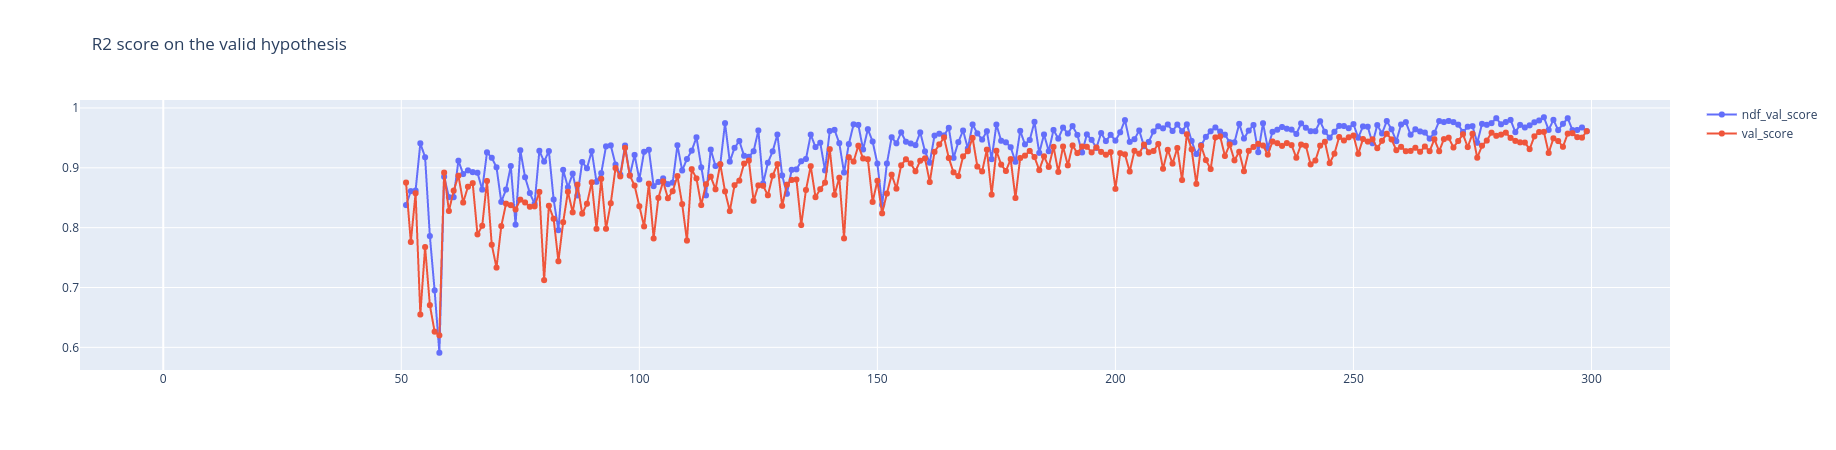

In [12]:
ndf_val_score = [frame.iloc[0]['ndf_val_score'] if isinstance(frame, pd.DataFrame) else frame for frame in iter_solution]
val_score = [frame.iloc[0]['val_score'] if isinstance(frame, pd.DataFrame) else frame for frame in iter_solution]

x = np.arange(len(val_score))
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ndf_val_score,
                    mode='lines+markers',
                    name='ndf_val_score'))
fig.add_trace(go.Scatter(x=x, y=val_score,
                    mode='lines+markers',
                    name='val_score'))
fig.update_layout(title='R2 score on the valid hypothesis')
fig.show()

### *Plotting objectives and search space for the last iteration of tuning
- Red points are Pare front from the hypothesis.
- Blue points are non-dominated solutions from evaluated points. Set of the best solutions available for this iteration.

**if the dimension of problem and objective space is 2*

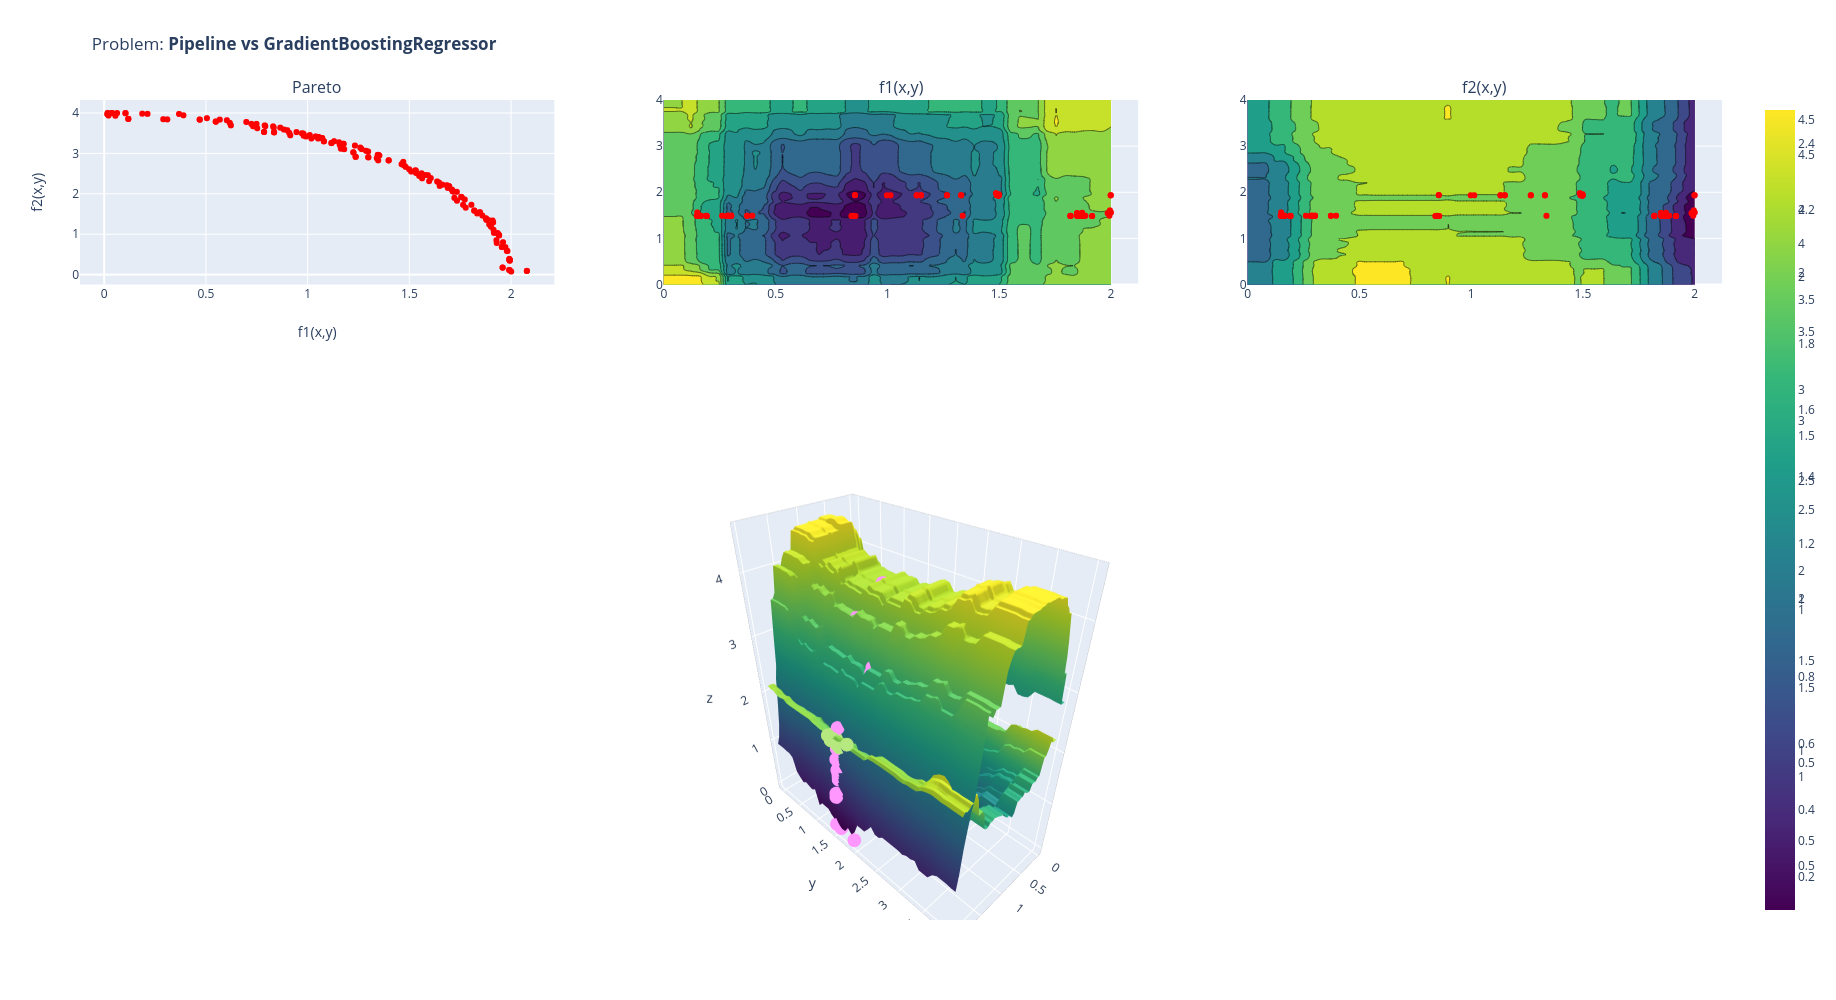

In [44]:
if OBJ==2 and DIM == 2:
    # Plot last population from TutorModel   
    X, y = gen.return_X_y()
    X = X.reset_index()
    y = y.reset_index()
    
    best_experiments = go.Scatter(x=y.loc[ndf[0],:].f1.values,
                         y=y.loc[ndf[0],:].f2.values,
                         mode='markers',
                         name=u'Dataset. Not-dominated results ',
                         showlegend=False,
                         line=dict(color='red')
                         )
    
    solver = tutor.solution.solver.values[0]
    fig = plot_mo(solver.problem, solver.population)
    fig.add_trace(best_experiments, row=1, col=1)
    plotly.offline.iplot(fig)

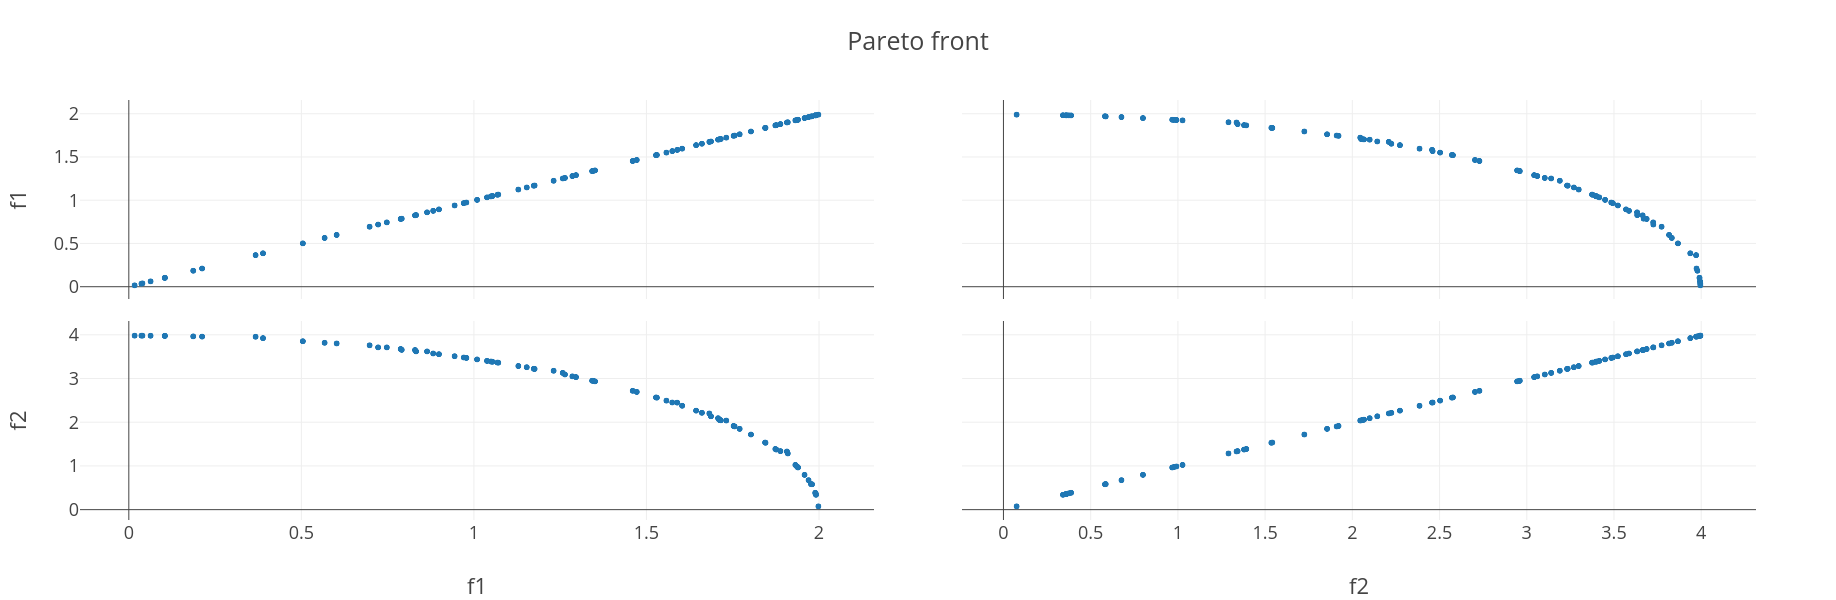

In [51]:
px.scatter_matrix(y.copy().loc[ndf[0],:], template="presentation", dimensions=list(y.drop(columns=['index']).columns), color_continuous_scale='Redblue', title="Pareto front").update_layout(coloraxis_showscale=False)

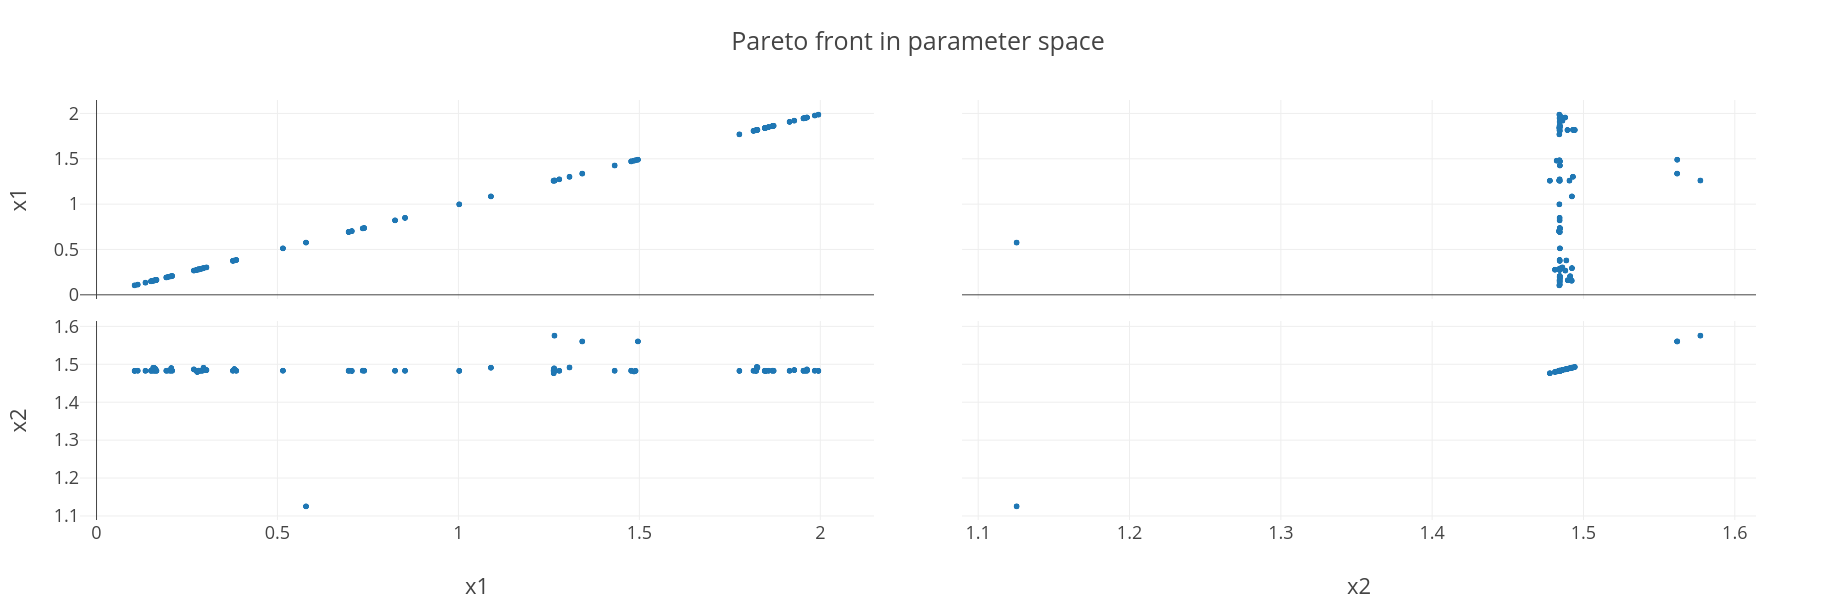

In [52]:
px.scatter_matrix(X.copy().loc[ndf[0],:], template="presentation" , dimensions=list(X.drop(columns=['index']).columns), color_continuous_scale='Jet', title="Pareto front in parameter space").update_layout(coloraxis_showscale=False)

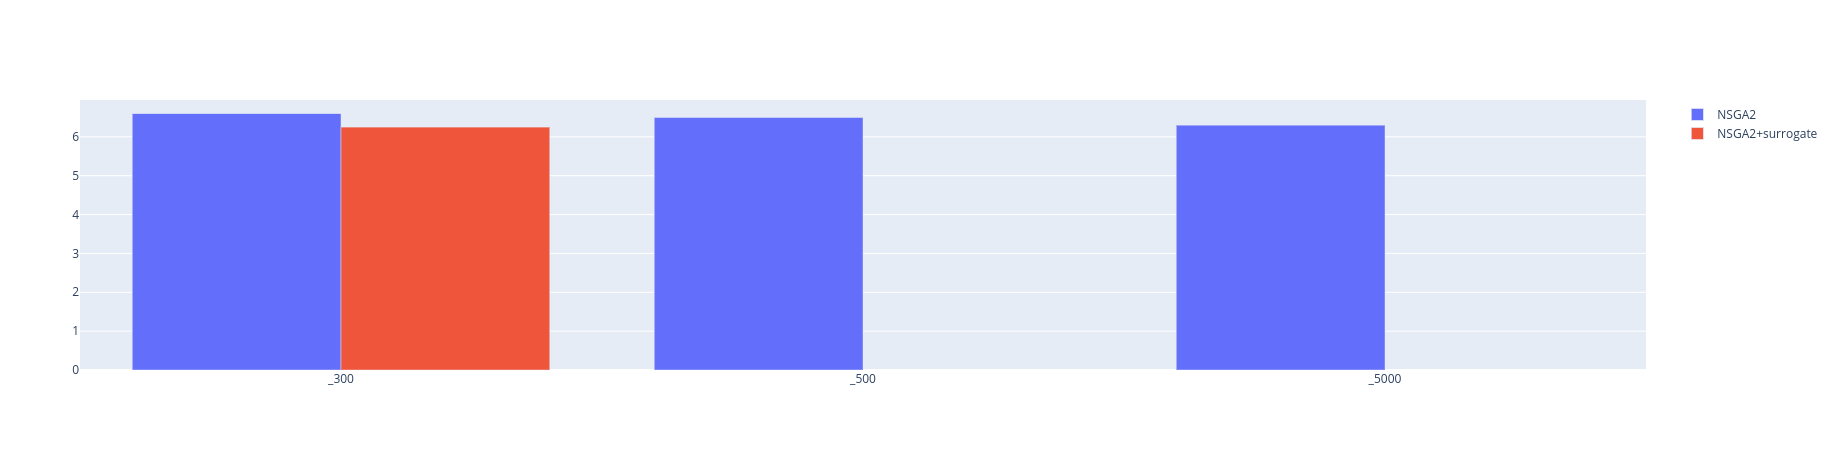

In [58]:
nsga = [6.6, 6.5, 6,3]
com = [3,25]


go.Figure(data=[
    go.Bar(name='NSGA2', x=['_300','_500','_5000'], y=[6.6, 6.5, 6.3]),
    go.Bar(name='NSGA2+surrogate', x=['_300','_500','_5000'], y=[6.25])
])